In [0]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip

--2019-04-08 07:02:37--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.249.87.81, 13.249.87.32, 13.249.87.90, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.249.87.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip.2’

data.zip.2          100%[===================>]   2.75M  --.-KB/s    in 0.07s   

2019-04-08 07:02:37 (40.1 MB/s) - ‘data.zip.2’ saved [2882130/2882130]

Archive:  data.zip
replace data/eng-fra.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: data/eng-fra.txt        
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  in

In [0]:
%matplotlib inline


Generating Names with a Character-Level RNN
*******************************************
**Author**: `Sean Robertson <https://github.com/spro/practical-pytorch>`_

In the :doc:`last tutorial </intermediate/char_rnn_classification_tutorial>`
we used a RNN to classify names into their language of origin. This time
we'll turn around and generate names from languages.

::

    > python sample.py Russian RUS
    Rovakov
    Uantov
    Shavakov

    > python sample.py German GER
    Gerren
    Ereng
    Rosher

    > python sample.py Spanish SPA
    Salla
    Parer
    Allan

    > python sample.py Chinese CHI
    Chan
    Hang
    Iun

We are still hand-crafting a small RNN with a few linear layers. The big
difference is instead of predicting a category after reading in all the
letters of a name, we input a category and output one letter at a time.
Recurrently predicting characters to form language (this could also be
done with words or other higher order constructs) is often referred to
as a "language model".

**Recommended Reading:**

I assume you have at least installed PyTorch, know Python, and
understand Tensors:

-  http://pytorch.org/ For installation instructions
-  :doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
-  :doc:`/beginner/pytorch_with_examples` for a wide and deep overview
-  :doc:`/beginner/former_torchies_tutorial` if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

-  `The Unreasonable Effectiveness of Recurrent Neural
   Networks <http://karpathy.github.io/2015/05/21/rnn-effectiveness/>`__
   shows a bunch of real life examples
-  `Understanding LSTM
   Networks <http://colah.github.io/posts/2015-08-Understanding-LSTMs/>`__
   is about LSTMs specifically but also informative about RNNs in
   general

I also suggest the previous tutorial, :doc:`/intermediate/char_rnn_classification_tutorial`


Preparing the Data
==================

.. Note::
   Download the data from
   `here <https://download.pytorch.org/tutorial/data.zip>`_
   and extract it to the current directory.

See the last tutorial for more detail of this process. In short, there
are a bunch of plain text files ``data/names/[Language].txt`` with a
name per line. We split lines into an array, convert Unicode to ASCII,
and end up with a dictionary ``{language: [names ...]}``.




In [0]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Dutch', 'Vietnamese', 'French', 'Japanese', 'Italian', 'Polish', 'Russian', 'German', 'Irish', 'Spanish', 'Portuguese', 'Arabic', 'Chinese', 'English', 'Czech', 'Greek', 'Korean', 'Scottish']
O'Neal


In [0]:
import random

# divide data into 20% validation and 80% training
category_lines_train = {}
category_lines_val = {}
for key in category_lines.keys():
  random.shuffle(category_lines[key])
  splitpoint = int(len(category_lines[key]) * 0.2)
  category_lines_val[key] = category_lines[key][:splitpoint]
  category_lines_train[key] = category_lines[key][splitpoint:]

Creating the Network
====================

This network extends `the last tutorial's RNN <#Creating-the-Network>`__
with an extra argument for the category tensor, which is concatenated
along with the others. The category tensor is a one-hot vector just like
the letter input.

We will interpret the output as the probability of the next letter. When
sampling, the most likely output letter is used as the next input
letter.

I added a second linear layer ``o2o`` (after combining hidden and
output) to give it more muscle to work with. There's also a dropout
layer, which `randomly zeros parts of its
input <https://arxiv.org/abs/1207.0580>`__ with a given probability
(here 0.1) and is usually used to fuzz inputs to prevent overfitting.
Here we're using it towards the end of the network to purposely add some
chaos and increase sampling variety.

.. figure:: https://i.imgur.com/jzVrf7f.png
   :alt:





In [0]:
# previous hidden unit, previous character, category
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
      
class RNN3(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN3, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined_i2o = torch.cat((category, input, hidden), 1)
        input_combined_i2h = torch.cat((category, torch.zeros_like(input), hidden), 1)
        hidden = self.i2h(input_combined_i2h)
        output = self.i2o(input_combined_i2o)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [0]:
# 1. previous hidden unit, previous character, category

# 2. previous hidden unit, previous character
# zero out the category tensor after the first iteration for both i2h and i2o

# 3, previous hidden unit, category
# zero out the input tensor at all iterations for i2h

# 4. previous hidden unit
# zero out the category tensor after the first iteration for both i2h and i2o
# zero out the input tensor at all iterations for i2h

Training
=========
Preparing for Training
----------------------

First of all, helper functions to get random pairs of (category, line):




In [0]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines_train[category])
    return category, line
  
def randomTestPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines_val[category])
    return category, line

For each timestep (that is, for each letter in a training word) the
inputs of the network will be
``(category, current letter, hidden state)`` and the outputs will be
``(next letter, next hidden state)``. So for each training set, we'll
need the category, a set of input letters, and a set of output/target
letters.

Since we are predicting the next letter from the current letter for each
timestep, the letter pairs are groups of consecutive letters from the
line - e.g. for ``"ABCD<EOS>"`` we would create ("A", "B"), ("B", "C"),
("C", "D"), ("D", "EOS").

.. figure:: https://i.imgur.com/JH58tXY.png
   :alt:

The category tensor is a `one-hot
tensor <https://en.wikipedia.org/wiki/One-hot>`__ of size
``<1 x n_categories>``. When training we feed it to the network at every
timestep - this is a design choice, it could have been included as part
of initial hidden state or some other strategy.




In [0]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

For convenience during training we'll make a ``randomTrainingExample``
function that fetches a random (category, line) pair and turns them into
the required (category, input, target) tensors.




In [0]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor
  
def randomTestExample():
    category, line = randomTestPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

Training the Network
--------------------

In contrast to classification, where only the last output is used, we
are making a prediction at every step, so we are calculating loss at
every step.

The magic of autograd allows you to simply sum these losses at each step
and call backward at the end.




In [0]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item() / input_line_tensor.size(0)

def test(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    return output, loss.item() / input_line_tensor.size(0)
  
def train2(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn2.initHidden()

    rnn2.zero_grad()

    loss = 0
    
    # first iteration, keep category_tensor
    output, hidden = rnn2(category_tensor, input_line_tensor[0], hidden)
    l = criterion(output, target_line_tensor[0])
    loss += l
    
    # zero out the category tensor after the first iteration for both i2h and i2o
    category_tensor = torch.zeros_like(category_tensor)
    
    for i in range(1, input_line_tensor.size(0)):
        output, hidden = rnn2(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn2.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item() / input_line_tensor.size(0)
  
def test2(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn2.initHidden()

    loss = 0
    
    # first iteration, keep category_tensor
    output, hidden = rnn2(category_tensor, input_line_tensor[0], hidden)
    l = criterion(output, target_line_tensor[0])
    loss += l
    
    # zero out the category tensor after the first iteration for both i2h and i2o
    category_tensor = torch.zeros_like(category_tensor)
    
    for i in range(1, input_line_tensor.size(0)):
        output, hidden = rnn2(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    return output, loss.item() / input_line_tensor.size(0)
  
def train3(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn3.initHidden()

    rnn3.zero_grad()

    loss = 0
    
    # zero out the input tensor at all iterations for i2h, already implemented in RNN3
    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn3(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn3.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item() / input_line_tensor.size(0)

def test3(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn3.initHidden()

    loss = 0
    
    # zero out the input tensor at all iterations for i2h, already implemented in RNN3
    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn3(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l
        
    return output, loss.item() / input_line_tensor.size(0)
  
def train4(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn4.initHidden()

    rnn4.zero_grad()
    
    loss = 0
    
    # first iteration, keep category_tensor
    output, hidden = rnn4(category_tensor, input_line_tensor[0], hidden)
    l = criterion(output, target_line_tensor[0])
    loss += l
    
    # zero out the category tensor after the first iteration for both i2h and i2o
    category_tensor = torch.zeros_like(category_tensor)
    
    # zero out the input tensor at all iterations for i2h, already implemented in RNN3
    for i in range(1, input_line_tensor.size(0)):
        output, hidden = rnn4(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn4.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item() / input_line_tensor.size(0)
  
def test4(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn4.initHidden()
    
    loss = 0
    
    # first iteration, keep category_tensor
    output, hidden = rnn4(category_tensor, input_line_tensor[0], hidden)
    l = criterion(output, target_line_tensor[0])
    loss += l
    
    # zero out the category tensor after the first iteration for both i2h and i2o
    category_tensor = torch.zeros_like(category_tensor)
    
    # zero out the input tensor at all iterations for i2h, already implemented in RNN3
    for i in range(1, input_line_tensor.size(0)):
        output, hidden = rnn4(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l
        
    return output, loss.item() / input_line_tensor.size(0)

To keep track of how long training takes I am adding a
``timeSince(timestamp)`` function which returns a human readable string:




In [0]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

Training is business as usual - call train a bunch of times and wait a
few minutes, printing the current time and loss every ``print_every``
examples, and keeping store of an average loss per ``plot_every`` examples
in ``all_losses`` for plotting later.




In [0]:
rnn = RNN(n_letters, 128, n_letters)
rnn2 = RNN(n_letters, 128, n_letters)
rnn3 = RNN3(n_letters, 128, n_letters)
rnn4 = RNN3(n_letters, 128, n_letters)

Model 1: previous hidden unit, previous character, category


In [0]:
n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters
val_losses = []
val_loss = 0

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss
    
    _, loss2 = test(*randomTestExample())
    val_loss += loss2

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0
        val_losses.append(val_loss / plot_every)
        val_loss = 0

0m 28s (5000 5%) 2.5550
0m 56s (10000 10%) 2.4254
1m 24s (15000 15%) 3.5410
1m 53s (20000 20%) 3.4732
2m 21s (25000 25%) 2.5560
2m 50s (30000 30%) 3.0005
3m 18s (35000 35%) 2.4482
3m 46s (40000 40%) 3.5457
4m 14s (45000 45%) 2.6106
4m 43s (50000 50%) 2.1952
5m 11s (55000 55%) 1.8218
5m 39s (60000 60%) 1.6413
6m 6s (65000 65%) 2.7755
6m 34s (70000 70%) 2.9752
7m 1s (75000 75%) 2.6903
7m 29s (80000 80%) 2.0007
7m 56s (85000 85%) 2.8014
8m 23s (90000 90%) 1.7490
8m 51s (95000 95%) 2.3166
9m 18s (100000 100%) 2.3889


Model 2: previous hidden unit, previous character




In [0]:
n_iters = 100000
print_every = 5000
plot_every = 500
all_losses_2 = []
total_loss_2 = 0 # Reset every plot_every iters
val_losses_2 = []
val_loss_2 = 0

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train2(*randomTrainingExample())
    total_loss_2 += loss
    
    _, loss2 = test2(*randomTestExample())
    val_loss_2 += loss2

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses_2.append(total_loss_2 / plot_every)
        total_loss_2 = 0
        val_losses_2.append(val_loss_2 / plot_every)
        val_loss_2 = 0

0m 27s (5000 5%) 2.5439
0m 54s (10000 10%) 2.4952
1m 21s (15000 15%) 3.9216
1m 49s (20000 20%) 2.8615
2m 16s (25000 25%) 2.0008
2m 43s (30000 30%) 4.1374
3m 11s (35000 35%) 2.4763
3m 38s (40000 40%) 3.2887
4m 5s (45000 45%) 2.2508
4m 33s (50000 50%) 2.1490
5m 0s (55000 55%) 2.4356
5m 28s (60000 60%) 2.9216
5m 56s (65000 65%) 2.3239
6m 23s (70000 70%) 2.8832
6m 51s (75000 75%) 2.1698
7m 19s (80000 80%) 2.2167
7m 47s (85000 85%) 2.6068
8m 15s (90000 90%) 1.8623
8m 43s (95000 95%) 3.2692
9m 11s (100000 100%) 2.0345


  Model 3:  previous hidden unit, category


In [0]:
n_iters = 100000
print_every = 5000
plot_every = 500
all_losses_3 = []
total_loss_3 = 0 # Reset every plot_every iters
val_losses_3 = []
val_loss_3 = 0

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train3(*randomTrainingExample())
    total_loss_3 += loss
    
    _, loss2 = test3(*randomTestExample())
    val_loss_3 += loss2

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses_3.append(total_loss_3 / plot_every)
        total_loss_3 = 0
        val_losses_3.append(val_loss_3 / plot_every)
        val_loss_3 = 0

0m 29s (5000 5%) 3.0431
0m 58s (10000 10%) 2.0887
1m 27s (15000 15%) 2.7416
1m 56s (20000 20%) 2.2802
2m 25s (25000 25%) 2.6067
2m 54s (30000 30%) 2.4060
3m 23s (35000 35%) 2.3714
3m 52s (40000 40%) 2.3484
4m 21s (45000 45%) 1.8603
4m 50s (50000 50%) 2.4445
5m 19s (55000 55%) 2.1098
5m 48s (60000 60%) 2.0675
6m 17s (65000 65%) 2.5232
6m 46s (70000 70%) 3.0100
7m 14s (75000 75%) 3.0887
7m 43s (80000 80%) 2.0730
8m 12s (85000 85%) 2.1330
8m 41s (90000 90%) 2.4424
9m 10s (95000 95%) 1.2878
9m 39s (100000 100%) 3.1540


Model 4: previous hidden unit

In [0]:
n_iters = 100000
print_every = 5000
plot_every = 500
all_losses_4 = []
total_loss_4 = 0 # Reset every plot_every iters
val_losses_4 = []
val_loss_4 = 0

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train4(*randomTrainingExample())
    total_loss_4 += loss
    
    _, loss2 = test4(*randomTestExample())
    val_loss_4 += loss2

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses_4.append(total_loss_4 / plot_every)
        total_loss_4 = 0
        val_losses_4.append(val_loss_4 / plot_every)
        val_loss_4 = 0

0m 28s (5000 5%) 3.6196
0m 57s (10000 10%) 3.3652
1m 26s (15000 15%) 2.7145
1m 55s (20000 20%) 2.2882
2m 24s (25000 25%) 2.4334
2m 53s (30000 30%) 2.3750
3m 22s (35000 35%) 2.6182
3m 51s (40000 40%) 2.8767
4m 21s (45000 45%) 2.4517
4m 50s (50000 50%) 3.1392
5m 20s (55000 55%) 2.8589
5m 49s (60000 60%) 2.8977
6m 18s (65000 65%) 2.3866
6m 48s (70000 70%) 3.1172
7m 18s (75000 75%) 2.7884
7m 48s (80000 80%) 2.4819
8m 17s (85000 85%) 2.3766
8m 47s (90000 90%) 2.1442
9m 17s (95000 95%) 2.3124
9m 46s (100000 100%) 2.5254


Plotting the Losses
-------------------

Plotting the historical loss from all\_losses shows the network
learning:




Model 1

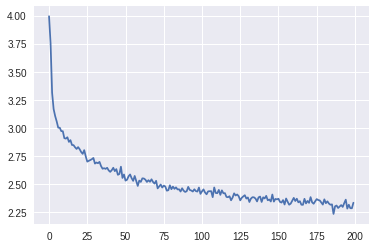

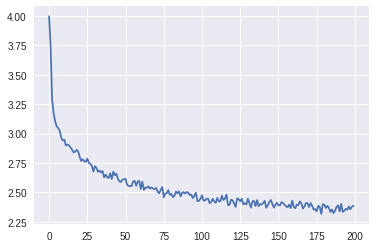

In [26]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.figure()
plt.plot(val_losses)

In [0]:
print("Final validaton loss is: %f" % val_losses[-1])

Final validaton loss is: 2.386896


Model 2

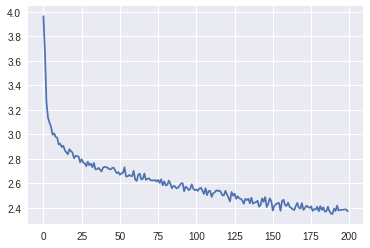

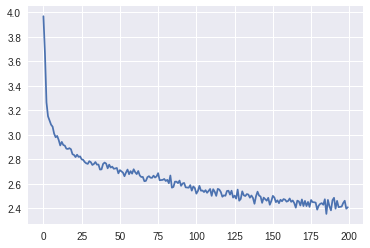

In [0]:
plt.figure()
plt.plot(all_losses_2)
plt.figure()
plt.plot(val_losses_2)

In [0]:
print("Final validaton loss is: %f" % val_losses_2[-1])

Final validaton loss is: 2.408706


Model 3

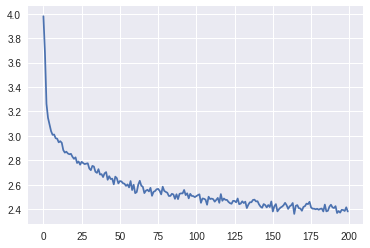

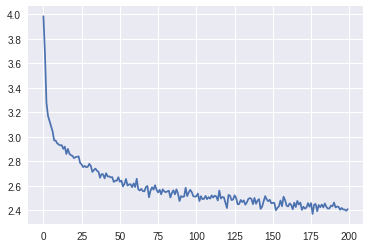

In [0]:
plt.figure()
plt.plot(all_losses_3)
plt.figure()
plt.plot(val_losses_3)

In [0]:
print("Final validaton loss is: %f" % val_losses_3[-1])

Final validaton loss is: 2.409573


Model 4

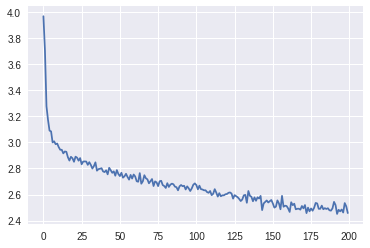

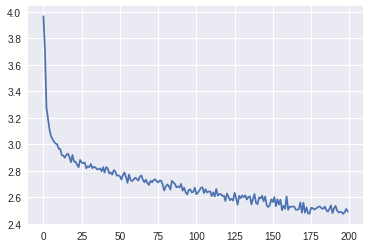

In [0]:
plt.figure()
plt.plot(all_losses_4)
plt.figure()
plt.plot(val_losses_4)

In [0]:
print("Final validaton loss is: %f" % val_losses_4[-1])

Final validaton loss is: 2.492100


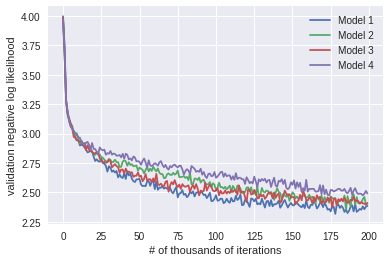

In [31]:
plt.figure()
plt.plot(val_losses, label='Model 1')
plt.plot(val_losses_2, label='Model 2')
plt.plot(val_losses_3, label='Model 3')
plt.plot(val_losses_4, label='Model 4')
plt.xlabel("# of thousands of iterations")
plt.ylabel("validation negative log likelihood")
plt.legend()

Sampling the Network
====================

To sample we give the network a letter and ask what the next one is,
feed that in as the next letter, and repeat until the EOS token.

-  Create tensors for input category, starting letter, and empty hidden
   state
-  Create a string ``output_name`` with the starting letter
-  Up to a maximum output length,

   -  Feed the current letter to the network
   -  Get the next letter from highest output, and next hidden state
   -  If the letter is EOS, stop here
   -  If a regular letter, add to ``output_name`` and continue

-  Return the final name

.. Note::
   Rather than having to give it a starting letter, another
   strategy would have been to include a "start of string" token in
   training and have the network choose its own starting letter.




In [0]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

Rakis
Uakinovev
Sakierov
Ganger
Eeren
Rour
Santara
Parez
Alara
Chan
Hang
Iin


Exercises
=========

-  Try with a different dataset of category -> line, for example:

   -  Fictional series -> Character name
   -  Part of speech -> Word
   -  Country -> City

-  Use a "start of sentence" token so that sampling can be done without
   choosing a start letter
-  Get better results with a bigger and/or better shaped network

   -  Try the nn.LSTM and nn.GRU layers
   -  Combine multiple of these RNNs as a higher level network


